函数定义

In [1]:
#包导入
import jieba
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
#打印原始文件内容
def print_sample_data(file_path, num_samples=3):
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= num_samples:
                break
            print(f"样本 {i+1}: {line.strip()}")

# 加载停用词表
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().splitlines())
    return stopwords 

#数据预处理
def load_and_process_data_with_example(file_path, stopwords, num_examples=3):
    data = []
    example_count = 0
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            category, content = line.strip().split('\t')
            words = [word for word in jieba.cut(content) if word not in stopwords and len(word.strip())>0]
            data.append((' '.join(words), category))
            # 打印处理后的样本示例
            if example_count < num_examples:
                print(f"处理后样本 {example_count + 1}: {' '.join(words)}")
                example_count += 1
    return zip(*data)

# 假设labels_train, labels_val, labels_test是之前划分好的标签集合
# 用来打印每个数据集的统计信息
def print_category_distribution(labels, dataset_name):
    # 统计每个类别的数量
    counter = Counter(labels)
    print(f"{dataset_name} 分布:")
    for category, count in counter.items():
        print(f"{category}: {count} ({count / len(labels) * 100:.2f}%)")
    print(f"总数: {len(labels)}\n")

# 设置matplotlib支持中文
plt.rcParams['font.sans-serif'] = ['STFangsong'] 
plt.rcParams['axes.unicode_minus'] = False    # 解决负号'-'显示为方块的问题
# 模型评估函数       
def evaluate_model(true_labels, pred_labels, dataset_name, labels=None):
    print(f"\n{dataset_name} Performance:\n")
    print(classification_report(true_labels, pred_labels, digits=4))

    macro_f1 = f1_score(true_labels, pred_labels, average='macro')
    micro_f1 = f1_score(true_labels, pred_labels, average='micro')

    print(f"{dataset_name} 宏平均 F1 分数: {macro_f1}")
    print(f"{dataset_name} 微平均 F1 分数: {micro_f1}\n")

    # 报告混淆矩阵
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{dataset_name} 混淆矩阵')
    plt.show()

# 1. 数据预处理

打印原始的txt文件内容。

In [2]:
print("原始数据示例:")
print_sample_data('cnews.txt')

原始数据示例:
样本 1: 体育	马晓旭意外受伤让国奥警惕 无奈大雨格外青睐殷家军记者傅亚雨沈阳报道 来到沈阳，国奥队依然没有摆脱雨水的困扰。7月31日下午6点，国奥队的日常训练再度受到大雨的干扰，无奈之下队员们只慢跑了25分钟就草草收场。31日上午10点，国奥队在奥体中心外场训练的时候，天就是阴沉沉的，气象预报显示当天下午沈阳就有大雨，但幸好队伍上午的训练并没有受到任何干扰。下午6点，当球队抵达训练场时，大雨已经下了几个小时，而且丝毫没有停下来的意思。抱着试一试的态度，球队开始了当天下午的例行训练，25分钟过去了，天气没有任何转好的迹象，为了保护球员们，国奥队决定中止当天的训练，全队立即返回酒店。在雨中训练对足球队来说并不是什么稀罕事，但在奥运会即将开始之前，全队变得“娇贵”了。在沈阳最后一周的训练，国奥队首先要保证现有的球员不再出现意外的伤病情况以免影响正式比赛，因此这一阶段控制训练受伤、控制感冒等疾病的出现被队伍放在了相当重要的位置。而抵达沈阳之后，中后卫冯萧霆就一直没有训练，冯萧霆是7月27日在长春患上了感冒，因此也没有参加29日跟塞尔维亚的热身赛。队伍介绍说，冯萧霆并没有出现发烧症状，但为了安全起见，这两天还是让他静养休息，等感冒彻底好了之后再恢复训练。由于有了冯萧霆这个例子，因此国奥队对雨中训练就显得特别谨慎，主要是担心球员们受凉而引发感冒，造成非战斗减员。而女足队员马晓旭在热身赛中受伤导致无缘奥运的前科，也让在沈阳的国奥队现在格外警惕，“训练中不断嘱咐队员们要注意动作，我们可不能再出这样的事情了。”一位工作人员表示。从长春到沈阳，雨水一路伴随着国奥队，“也邪了，我们走到哪儿雨就下到哪儿，在长春几次训练都被大雨给搅和了，没想到来沈阳又碰到这种事情。”一位国奥球员也对雨水的“青睐”有些不解。
样本 2: 体育	商瑞华首战复仇心切 中国玫瑰要用美国方式攻克瑞典多曼来了，瑞典来了，商瑞华首战求3分的信心也来了。距离首战72小时当口，中国女足彻底从“恐瑞症”当中获得解脱，因为商瑞华已经找到了瑞典人的软肋。找到软肋，保密4月20日奥运会分组抽签结果出来后，中国姑娘就把瑞典锁定为关乎奥运成败的头号劲敌，因为除了浦玮等个别老将之外，现役女足将士竟然没有人尝过击败瑞典的滋味。在中瑞两队共计15次交锋的历史上，中国队6胜3平6负与瑞典队平分秋色，但从2001年起至今近8年

进行数据预处理和打印处理之后的文件内容。

In [3]:
stopwords = load_stopwords('cnews.vocab.txt')  

contents, labels = load_and_process_data_with_example('cnews.txt', stopwords)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/gn/dnt6kjfs4yqfvfj12rrn4t680000gn/T/jieba.cache
Loading model cost 0.296 seconds.
Prefix dict has been built successfully.


处理后样本 1: 马晓旭 意外 受伤 国奥 警惕 无奈 大雨 格外 青睐 殷家 记者 傅亚雨 沈阳 报道 来到 沈阳 国奥队 依然 没有 摆脱 雨水 困扰 31 下午 国奥队 日常 训练 再度 受到 大雨 干扰 无奈 之下 队员 慢跑 25 分钟 草草收场 31 上午 10 国奥队 奥体中心 外场 训练 时候 就是 阴沉沉 气象预报 显示 当天 下午 沈阳 大雨 幸好 队伍 上午 训练 没有 受到 任何 干扰 下午 球队 抵达 训练场 大雨 已经 几个 小时 而且 丝毫 没有 停下来 意思 试一试 态度 球队 开始 当天 下午 例行 训练 25 分钟 过去 天气 没有 任何 转好 迹象 为了 保护 球员 国奥队 决定 中止 当天 训练 全队 立即 返回 酒店 训练 足球队 来说 不是 什么 稀罕 奥运会 即将 开始 之前 全队 变得 娇贵 沈阳 最后 一周 训练 国奥队 首先 保证 现有 球员 不再 出现意外 伤病 情况 以免 影响 正式 比赛 因此 这一 阶段 控制 训练 受伤 控制 感冒 疾病 出现 队伍 放在 相当 重要 位置 抵达 沈阳 之后 后卫 冯萧霆 一直 没有 训练 冯萧霆 27 长春 患上 感冒 因此 没有 参加 29 塞尔维亚 热身赛 队伍 介绍 冯萧霆 没有 出现 发烧 症状 为了 安全 两天 还是 静养 休息 感冒 彻底 之后 恢复 训练 由于 冯萧霆 这个 例子 因此 国奥队 对雨中 训练 显得 特别 谨慎 主要 担心 球员 受凉 引发 感冒 造成 非战斗 减员 女足 队员 马晓旭 热身赛 受伤 导致 无缘 奥运 前科 沈阳 国奥队 现在 格外 警惕 训练 不断 嘱咐 队员 注意 动作 我们 不能 再出 这样 事情 一位 工作人员 表示 长春 沈阳 雨水 一路 伴随 国奥队 我们 哪儿 哪儿 长春 几次 训练 大雨 搅和 没想到 沈阳 碰到 这种 事情 一位 国奥 球员 雨水 青睐 有些 不解
处理后样本 2: 商瑞华 首战 复仇 心切 中国 玫瑰 美国 方式 攻克 瑞典 多曼来 瑞典 商瑞华 首战 信心 距离 首战 72 小时 中国女足 彻底 恐瑞症 当中 获得 解脱 因为 商瑞华 已经 找到 瑞典人 软肋 找到 软肋 保密 20 奥运会 分组 抽签 结果 出来 中国 姑娘 瑞典 锁定 关乎 奥运 成败 头号 劲敌 因为 除了 浦玮 个别

# 2. 划分数据集

1. 不均衡划分数据集

In [4]:
# 数据集划分...
contents_train_val01, contents_test01, labels_train_val01, labels_test01 = train_test_split(
    contents, labels, test_size=0.1, random_state=42)
contents_train01, contents_val01, labels_train01, labels_val01 = train_test_split(
    contents_train_val01, labels_train_val01, test_size=1/9, random_state=42)

# 打印各数据集的类别分布信息
print_category_distribution(labels_train01, "训练集")
print_category_distribution(labels_val01, "验证集")
print_category_distribution(labels_test01, "测试集")

训练集 分布:
家居: 4004 (16.68%)
科技: 4001 (16.67%)
教育: 4005 (16.69%)
体育: 4004 (16.68%)
财经: 4009 (16.70%)
房产: 3977 (16.57%)
总数: 24000

验证集 分布:
家居: 486 (16.20%)
科技: 492 (16.40%)
教育: 513 (17.10%)
体育: 511 (17.03%)
财经: 510 (17.00%)
房产: 488 (16.27%)
总数: 3000

测试集 分布:
体育: 485 (16.17%)
科技: 507 (16.90%)
财经: 481 (16.03%)
家居: 510 (17.00%)
房产: 535 (17.83%)
教育: 482 (16.07%)
总数: 3000



2. 均衡划分数据集

In [5]:
# 数据集划分...
contents_train_val02, contents_test02, labels_train_val02, labels_test02 = train_test_split(
    list(contents), list(labels), test_size=0.1, stratify=list(labels), random_state=42)
contents_train02, contents_val02, labels_train02, labels_val02 = train_test_split(
    contents_train_val02, labels_train_val02, test_size=1/9, stratify=labels_train_val02, random_state=42)

# 打印各数据集的类别分布信息
print_category_distribution(labels_train02, "训练集")
print_category_distribution(labels_val02, "验证集")
print_category_distribution(labels_test02, "测试集")

训练集 分布:
家居: 4000 (16.67%)
体育: 4000 (16.67%)
财经: 4000 (16.67%)
教育: 4000 (16.67%)
科技: 4000 (16.67%)
房产: 4000 (16.67%)
总数: 24000

验证集 分布:
体育: 500 (16.67%)
家居: 500 (16.67%)
教育: 500 (16.67%)
房产: 500 (16.67%)
财经: 500 (16.67%)
科技: 500 (16.67%)
总数: 3000

测试集 分布:
财经: 500 (16.67%)
教育: 500 (16.67%)
体育: 500 (16.67%)
科技: 500 (16.67%)
房产: 500 (16.67%)
家居: 500 (16.67%)
总数: 3000



# 3. 特征工程

In [6]:
# 不均衡数据集特征提取...
vectorizer01 = TfidfVectorizer()
X_train01 = vectorizer01.fit_transform(contents_train01)
X_val01 = vectorizer01.transform(contents_val01)
X_test01 = vectorizer01.transform(contents_test01)

In [7]:
# 处理类别不平衡问题（可选）
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train01, labels_train01)

In [8]:
# 均衡数据集特征提取...
vectorizer02 = TfidfVectorizer()
X_train02 = vectorizer02.fit_transform(contents_train02)
X_val02 = vectorizer02.transform(contents_val02)
X_test02 = vectorizer02.transform(contents_test02)

# 4. 模型训练与评估

1. 朴素贝叶斯模型


验证集 Performance:

              precision    recall  f1-score   support

          体育     0.9961    0.9980    0.9971       511
          家居     0.9909    0.8951    0.9405       486
          房产     0.8624    0.9631    0.9100       488
          教育     0.9314    0.9532    0.9422       513
          科技     0.9435    0.9512    0.9474       492
          财经     0.9627    0.9118    0.9366       510

    accuracy                         0.9457      3000
   macro avg     0.9478    0.9454    0.9456      3000
weighted avg     0.9482    0.9457    0.9459      3000

验证集 宏平均 F1 分数: 0.9456166319462952
验证集 微平均 F1 分数: 0.9456666666666667



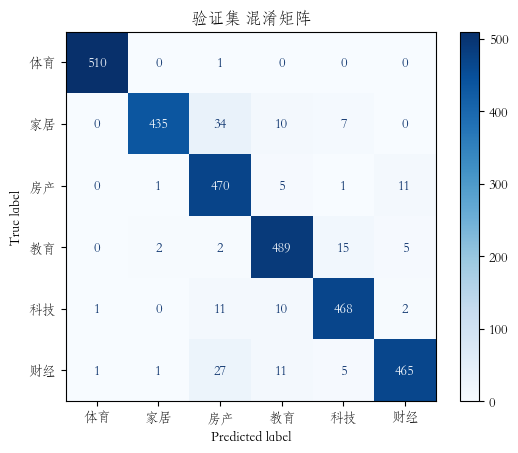


测试集 Performance:

              precision    recall  f1-score   support

          体育     0.9938    0.9979    0.9959       485
          家居     0.9806    0.8922    0.9343       510
          房产     0.8917    0.9850    0.9361       535
          教育     0.9202    0.9336    0.9269       482
          科技     0.9421    0.9625    0.9522       507
          财经     0.9690    0.9085    0.9378       481

    accuracy                         0.9470      3000
   macro avg     0.9496    0.9466    0.9472      3000
weighted avg     0.9488    0.9470    0.9470      3000

测试集 宏平均 F1 分数: 0.9471793435160182
测试集 微平均 F1 分数: 0.947



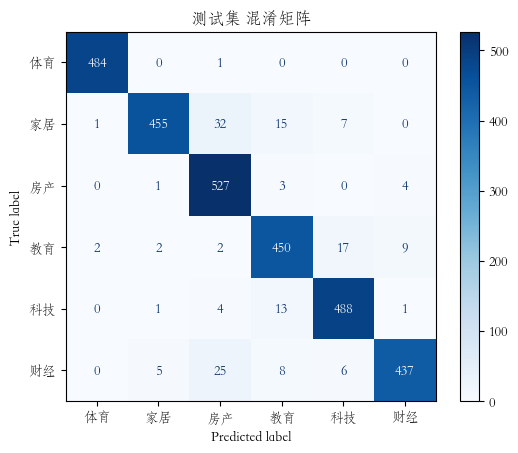

In [9]:
#不均衡数据集模型训练
nb_classifier01 = MultinomialNB()
nb_classifier01.fit(X_train_resampled, y_train_resampled)

#模型评估
predictions_val_nb01 = nb_classifier01.predict(X_val01)
predictions_test_nb01 = nb_classifier01.predict(X_test01)

# 使用评估函数
unique_labels01 = sorted(set(labels))  # 获取所有类别标签
evaluate_model(labels_val01, predictions_val_nb01, "验证集", unique_labels01)
evaluate_model(labels_test01, predictions_test_nb01, "测试集", unique_labels01)


验证集 Performance:

              precision    recall  f1-score   support

          体育     0.9960    0.9960    0.9960       500
          家居     0.9829    0.9220    0.9515       500
          房产     0.9028    0.9660    0.9333       500
          教育     0.9133    0.9480    0.9303       500
          科技     0.9528    0.9680    0.9603       500
          财经     0.9701    0.9100    0.9391       500

    accuracy                         0.9517      3000
   macro avg     0.9530    0.9517    0.9518      3000
weighted avg     0.9530    0.9517    0.9518      3000

验证集 宏平均 F1 分数: 0.951763919281421
验证集 微平均 F1 分数: 0.9516666666666667



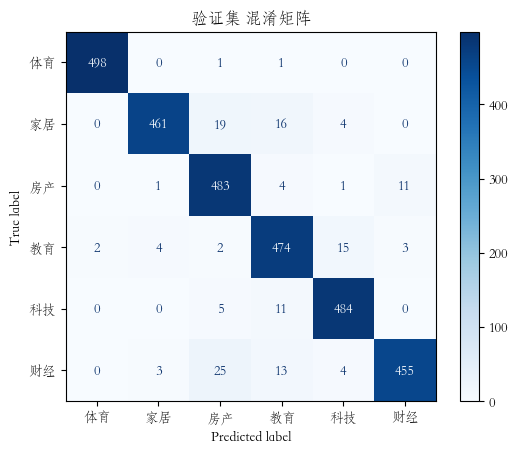


测试集 Performance:

              precision    recall  f1-score   support

          体育     0.9980    1.0000    0.9990       500
          家居     0.9851    0.9280    0.9557       500
          房产     0.9021    0.9580    0.9292       500
          教育     0.9411    0.9580    0.9495       500
          科技     0.9546    0.9680    0.9613       500
          财经     0.9605    0.9240    0.9419       500

    accuracy                         0.9560      3000
   macro avg     0.9569    0.9560    0.9561      3000
weighted avg     0.9569    0.9560    0.9561      3000

测试集 宏平均 F1 分数: 0.9560889574836446
测试集 微平均 F1 分数: 0.956



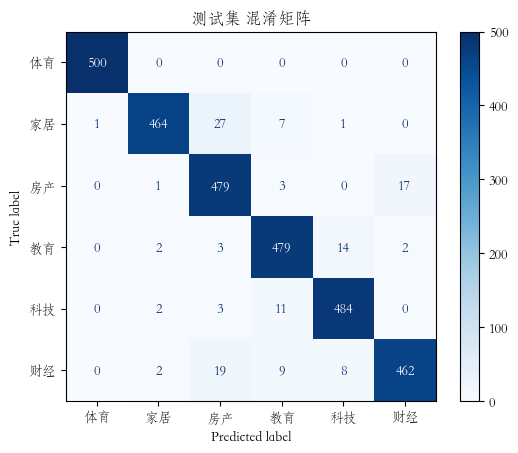

In [10]:
# 均衡数据集模型训练与评估...
nb_classifier02 = MultinomialNB()
nb_classifier02.fit(X_train02, labels_train02)

#模型评估
predictions_val_nb02 = nb_classifier02.predict(X_val02)
predictions_test_nb02 = nb_classifier02.predict(X_test02)

# 使用评估函数
unique_labels02 = sorted(set(labels))  # 获取所有类别标签
evaluate_model(labels_val02, predictions_val_nb02, "验证集", unique_labels02)
evaluate_model(labels_test02, predictions_test_nb02, "测试集", unique_labels02)

2. KNN模型


验证集 Performance:

              precision    recall  f1-score   support

          体育     0.9787    0.9883    0.9834       511
          家居     0.9406    0.9444    0.9425       486
          房产     0.9145    0.9426    0.9284       488
          教育     0.9414    0.9084    0.9246       513
          科技     0.9390    0.9390    0.9390       492
          财经     0.9427    0.9353    0.9390       510

    accuracy                         0.9430      3000
   macro avg     0.9428    0.9430    0.9428      3000
weighted avg     0.9431    0.9430    0.9429      3000

验证集 宏平均 F1 分数: 0.9428185343091698
验证集 微平均 F1 分数: 0.943



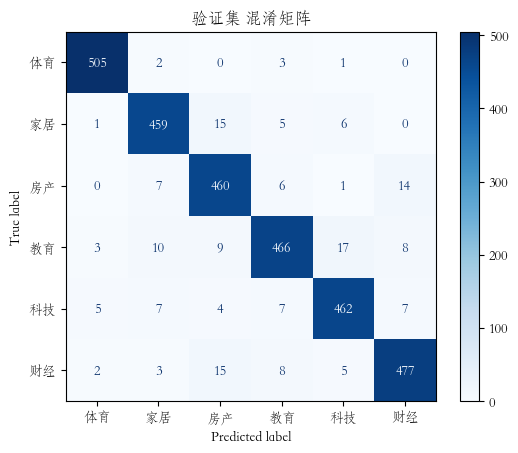


测试集 Performance:

              precision    recall  f1-score   support

          体育     0.9837    0.9979    0.9908       485
          家居     0.9556    0.9275    0.9413       510
          房产     0.9120    0.9682    0.9393       535
          教育     0.9389    0.8921    0.9149       482
          科技     0.9191    0.9191    0.9191       507
          财经     0.9354    0.9335    0.9344       481

    accuracy                         0.9400      3000
   macro avg     0.9408    0.9397    0.9400      3000
weighted avg     0.9403    0.9400    0.9398      3000

测试集 宏平均 F1 分数: 0.9399678812340494
测试集 微平均 F1 分数: 0.94



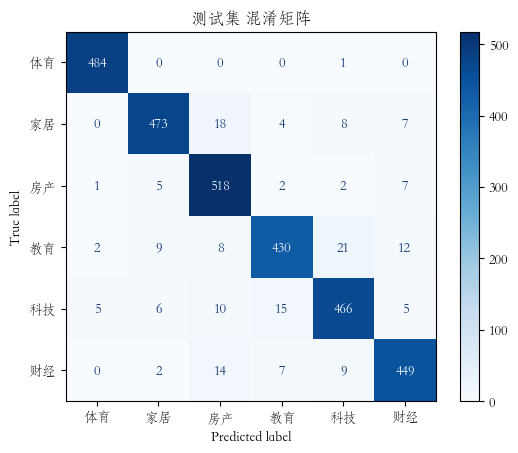

In [11]:
#不均衡数据集模型训练
knn_classifier01 = KNeighborsClassifier(n_neighbors=5)  # 创建KNN分类器实例
knn_classifier01.fit(X_train_resampled, y_train_resampled)  # 训练模型
#模型评估
predictions_val_knn01 = knn_classifier01.predict(X_val01)
predictions_test_knn01 = knn_classifier01.predict(X_test01)

# 使用评估函数
unique_labels03 = sorted(set(labels))  # 获取所有类别标签
evaluate_model(labels_val01, predictions_val_knn01, "验证集", unique_labels03)
evaluate_model(labels_test01, predictions_test_knn01, "测试集", unique_labels03)


验证集 Performance:

              precision    recall  f1-score   support

          体育     0.9785    1.0000    0.9891       500
          家居     0.9498    0.9460    0.9479       500
          房产     0.9141    0.9360    0.9249       500
          教育     0.9308    0.9140    0.9223       500
          科技     0.9418    0.9380    0.9399       500
          财经     0.9429    0.9240    0.9333       500

    accuracy                         0.9430      3000
   macro avg     0.9430    0.9430    0.9429      3000
weighted avg     0.9430    0.9430    0.9429      3000

验证集 宏平均 F1 分数: 0.9429050766742009
验证集 微平均 F1 分数: 0.943



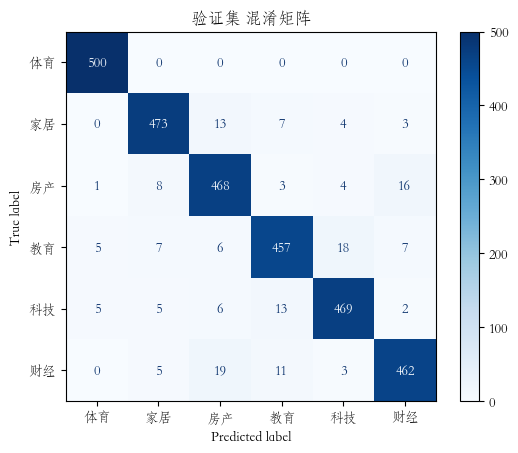


测试集 Performance:

              precision    recall  f1-score   support

          体育     0.9784    0.9960    0.9871       500
          家居     0.9525    0.9620    0.9572       500
          房产     0.9222    0.9480    0.9349       500
          教育     0.9442    0.9140    0.9289       500
          科技     0.9475    0.9380    0.9427       500
          财经     0.9615    0.9480    0.9547       500

    accuracy                         0.9510      3000
   macro avg     0.9510    0.9510    0.9509      3000
weighted avg     0.9510    0.9510    0.9509      3000

测试集 宏平均 F1 分数: 0.950916544209592
测试集 微平均 F1 分数: 0.951



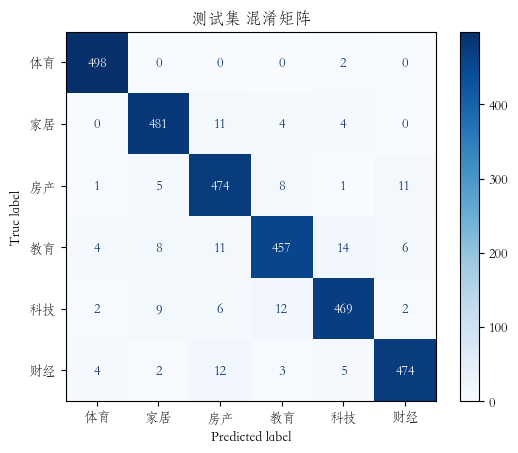

In [12]:
# 均衡数据集模型训练
knn_classifier02 = KNeighborsClassifier(n_neighbors=5)  # 创建KNN分类器实例
knn_classifier02.fit(X_train02, labels_train02)  # 训练模型

#模型评估
predictions_val_knn02 = knn_classifier02.predict(X_val02)
predictions_test_knn02 = knn_classifier02.predict(X_test02)

# 使用评估函数
unique_labels04 = sorted(set(labels))  # 获取所有类别标签
evaluate_model(labels_val02, predictions_val_knn02, "验证集", unique_labels04)
evaluate_model(labels_test02, predictions_test_knn02, "测试集", unique_labels04)

3. 梯度提升决策树（Gradient Boosting Decision Tree, GBDT）模型


验证集 Performance:

              precision    recall  f1-score   support

          体育     0.9883    0.9922    0.9902       511
          家居     0.9315    0.9794    0.9549       486
          房产     0.9898    0.9939    0.9918       488
          教育     0.9750    0.9123    0.9426       513
          科技     0.9434    0.9492    0.9463       492
          财经     0.9569    0.9588    0.9579       510

    accuracy                         0.9640      3000
   macro avg     0.9642    0.9643    0.9640      3000
weighted avg     0.9644    0.9640    0.9639      3000

验证集 宏平均 F1 分数: 0.9639505915083281
验证集 微平均 F1 分数: 0.964



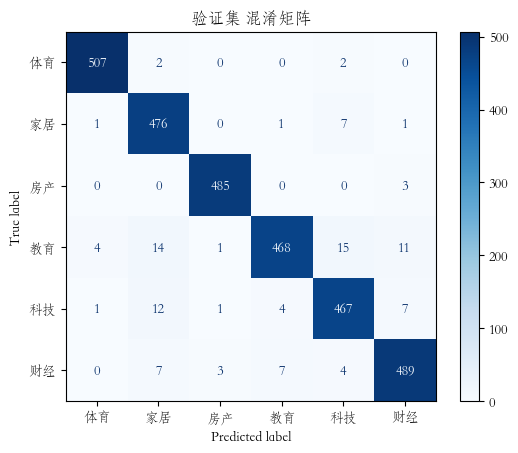


测试集 Performance:

              precision    recall  f1-score   support

          体育     0.9897    0.9938    0.9918       485
          家居     0.8989    0.9765    0.9361       510
          房产     0.9925    0.9907    0.9916       535
          教育     0.9329    0.8942    0.9131       482
          科技     0.9401    0.8974    0.9183       507
          财经     0.9603    0.9563    0.9583       481

    accuracy                         0.9520      3000
   macro avg     0.9524    0.9515    0.9515      3000
weighted avg     0.9526    0.9520    0.9519      3000

测试集 宏平均 F1 分数: 0.9515289992670063
测试集 微平均 F1 分数: 0.952



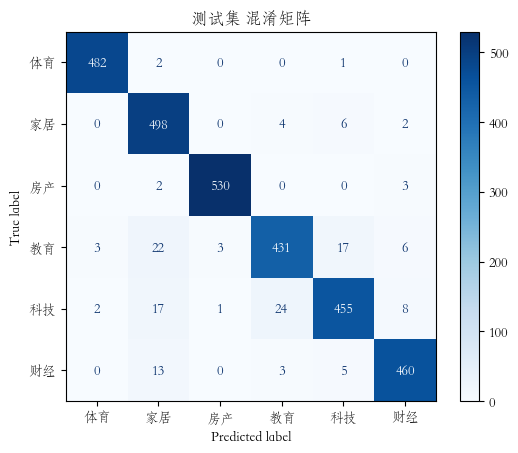

In [13]:
# 不均衡数据集模型训练

#创建GBDT分类器实例
gbdt_classifier01 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)  # 创建GBDT分类器实例
# 使用训练数据拟合模型
gbdt_classifier01.fit(X_train_resampled, y_train_resampled)

# 模型评估 - 使用GBDT模型进行预测
predictions_val_gbdt01 = gbdt_classifier01.predict(X_val01)
predictions_test_gbdt01 = gbdt_classifier01.predict(X_test01)

# 使用评估函数
unique_labels05 = sorted(set(labels))  # 获取所有类别标签
evaluate_model(labels_val01, predictions_val_gbdt01, "验证集", unique_labels05)
evaluate_model(labels_test01, predictions_test_gbdt01, "测试集", unique_labels05)


验证集 Performance:

              precision    recall  f1-score   support

          体育     0.9940    0.9920    0.9930       500
          家居     0.9104    0.9760    0.9421       500
          房产     0.9980    0.9960    0.9970       500
          教育     0.9580    0.9120    0.9344       500
          科技     0.9455    0.9360    0.9407       500
          财经     0.9697    0.9600    0.9648       500

    accuracy                         0.9620      3000
   macro avg     0.9626    0.9620    0.9620      3000
weighted avg     0.9626    0.9620    0.9620      3000

验证集 宏平均 F1 分数: 0.9620047999623472
验证集 微平均 F1 分数: 0.962



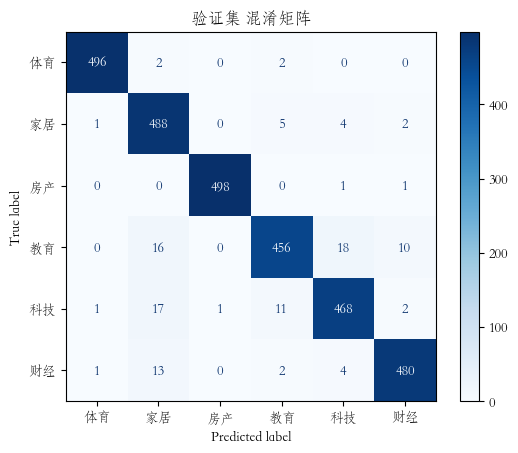


测试集 Performance:

              precision    recall  f1-score   support

          体育     0.9980    0.9960    0.9970       500
          家居     0.9286    0.9880    0.9574       500
          房产     0.9960    0.9960    0.9960       500
          教育     0.9687    0.9280    0.9479       500
          科技     0.9518    0.9480    0.9499       500
          财经     0.9715    0.9560    0.9637       500

    accuracy                         0.9687      3000
   macro avg     0.9691    0.9687    0.9686      3000
weighted avg     0.9691    0.9687    0.9686      3000

测试集 宏平均 F1 分数: 0.9686461402764223
测试集 微平均 F1 分数: 0.9686666666666667



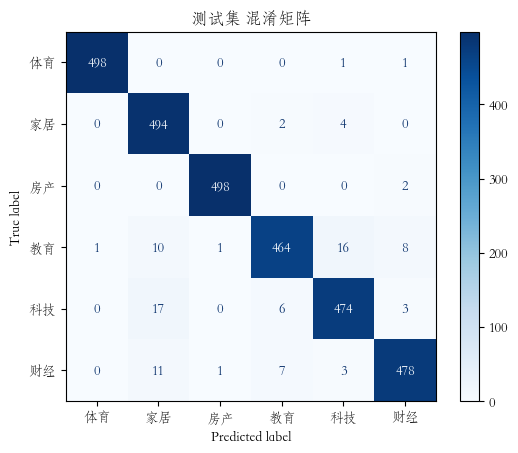

In [14]:
# 均衡数据集模型训练

#创建GBDT分类器实例
gbdt_classifier02 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
# 使用训练数据拟合模型
gbdt_classifier02.fit(X_train02, labels_train02)

# 模型评估 - 使用GBDT模型进行预测
predictions_val_gbdt02 = gbdt_classifier02.predict(X_val02)
predictions_test_gbdt02 = gbdt_classifier02.predict(X_test02)
# 使用评估函数
unique_labels06 = sorted(set(labels))  # 获取所有类别标签
evaluate_model(labels_val02, predictions_val_gbdt02, "验证集", unique_labels06)
evaluate_model(labels_test02, predictions_test_gbdt02, "测试集", unique_labels06)